In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits as mp
import seaborn as sns
import src.make_data
import csv

%matplotlib inline
plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('data/clean_fire_data.csv')


In [4]:
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_end'] = pd.to_datetime(df['date_end'])


### Cause of Fire EDA

In [5]:
def group_cause(cause):
    
    human_activity = ['Debris Burning', 'Campfire', 'Arson', 'Children', 'Fireworks', 'Smoking', 'Equipment Use']
    other = ['Missing/Undefined', 'Powerline', 'Railroad', 'Structure', 'Lightning', 'Miscellaneous']
    #nature = ['Lightning']
    
    if cause in human_activity: 
        return 'human'
    elif cause in other:
        return 'other'
    

In [6]:
df['cause_group'] = np.vectorize(group_cause)(df['stat_cause_descr'])

In [7]:
cause_groupby = df.groupby('stat_cause_descr')
cause_group_grouby = df.groupby('cause_group')

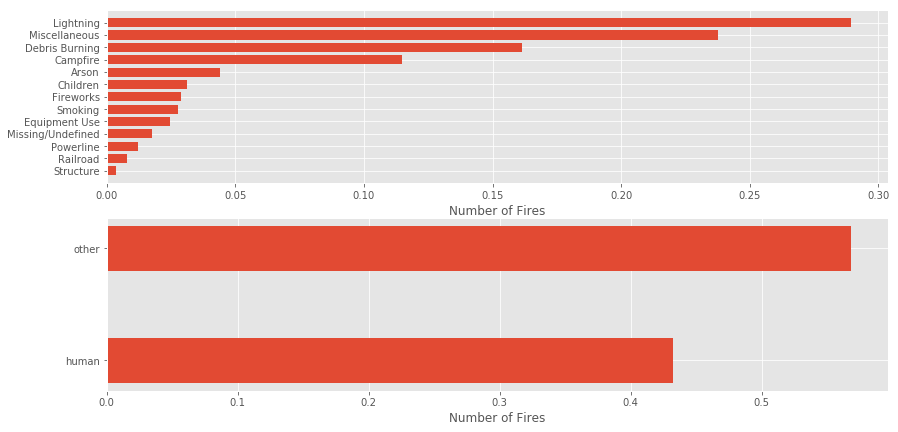

In [8]:
fig, axs = plt.subplots(2,1, figsize=(14,7))

cause_counts = cause_groupby.count().sort_values('fire_year', ascending=True)
total_fires = cause_counts.iloc[:,1].values.sum()
axs[0].barh(np.linspace(0,13,13), cause_counts['stat_cause_code']/total_fires, tick_label=cause_counts.index)
axs[0].set_xlabel('Number of Fires')

cause_group_counts = cause_group_grouby.count().sort_values('fire_year', ascending=True)
axs[1].barh(np.linspace(0,2,2), cause_group_counts['stat_cause_code']/total_fires, tick_label=cause_group_counts.index)
axs[1].set_xlabel('Number of Fires')


In [9]:
def univariate_plot(var1, ax, df=df):
    g = df.groupby([var1, 'cause_group'], as_index=False)
    counts = g.count()
    counts = counts[[var1, 'cause_group', 'state']]
    counts = counts.pivot_table(values='state', index=var1, columns='cause_group')
    counts['prob_human'] = counts['human']/(counts['other']+counts['human'])
    
    ax.plot(counts.index, counts['prob_human'], label='Probability of human cause')
    ax.bar(counts.index, (counts['human']+counts['other'])/(counts['human'].sum()+counts['other'].sum()), label='Fraction of fires')
    ax.set_xlabel(var1)
    ax.legend(loc=0)
    ax.set_title("Probability of human cause vs {}".format(var1))



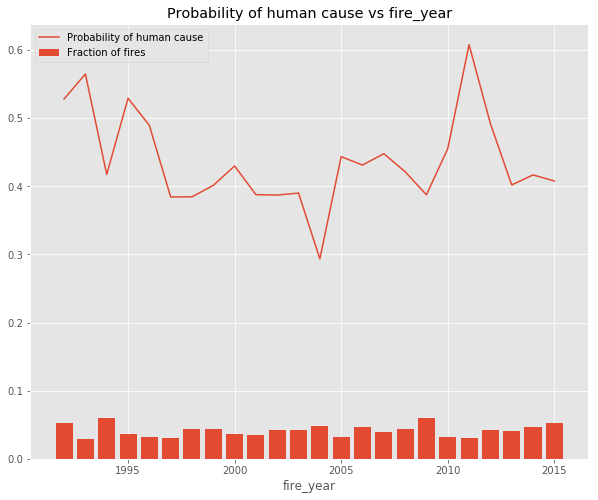

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
univariate_plot('fire_year', ax)

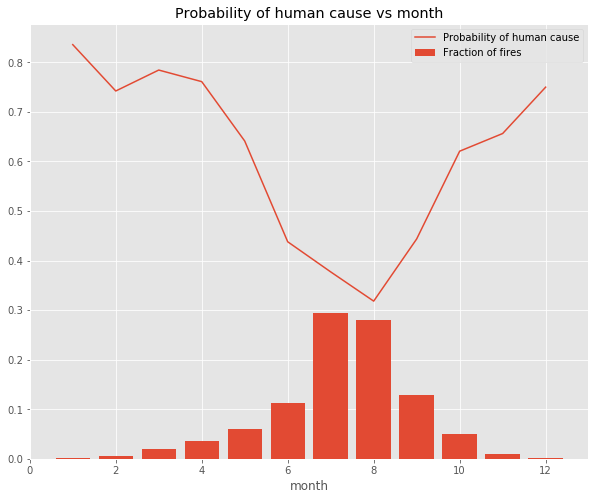

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
univariate_plot('month', ax)
    

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
univariate_plot('fire_size_class', ax)
    

In [ ]:
def univariate_plot(var1, ax, df=df):
    g = df.groupby([var1, 'fraud'], as_index=False)
    counts = g.count()
    counts = counts[[var1, 'fraud', 'body_length']]
    counts = counts.pivot_table(values='body_length', index=var1, columns='fraud')
    counts['prob_fraud'] = counts.iloc[:,1]/(counts.iloc[:,1]+counts.iloc[:,0])
    
    ax.plot(np.arange(len(counts.index)), counts['prob_fraud'], label='Probability of fraud', c='b', linewidth=4)
    ax.bar(np.arange(len(counts.index)), (counts.iloc[:,1]+counts.iloc[:,0])/(counts.iloc[:,1].sum()+counts.iloc[:,0].sum()), label='Fraction of events')
    ax.set_xlabel(var1)
    ax.legend(loc=0, fontsize='xx-large')
    #ax.set_title("Probability of fraud vs {}".format(var1))
    ax.tick_params(axis='both', which='major', labelsize=20)
    #return counts

In [ ]:
bins = np.arange(0,10000,500)
df['binned_pay'] = pd.cut(df['avg_past_payout'], bins)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
test = univariate_plot('binned_age', ax)
age_bins = np.arange(0,1000,100)
ax.set_xlabel('User age', fontsize=24)
ax.set_xticklabels(age_bins)
ax.set_xticks(np.arange(0,21,2))
plt.savefig('prob_by_userage')

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

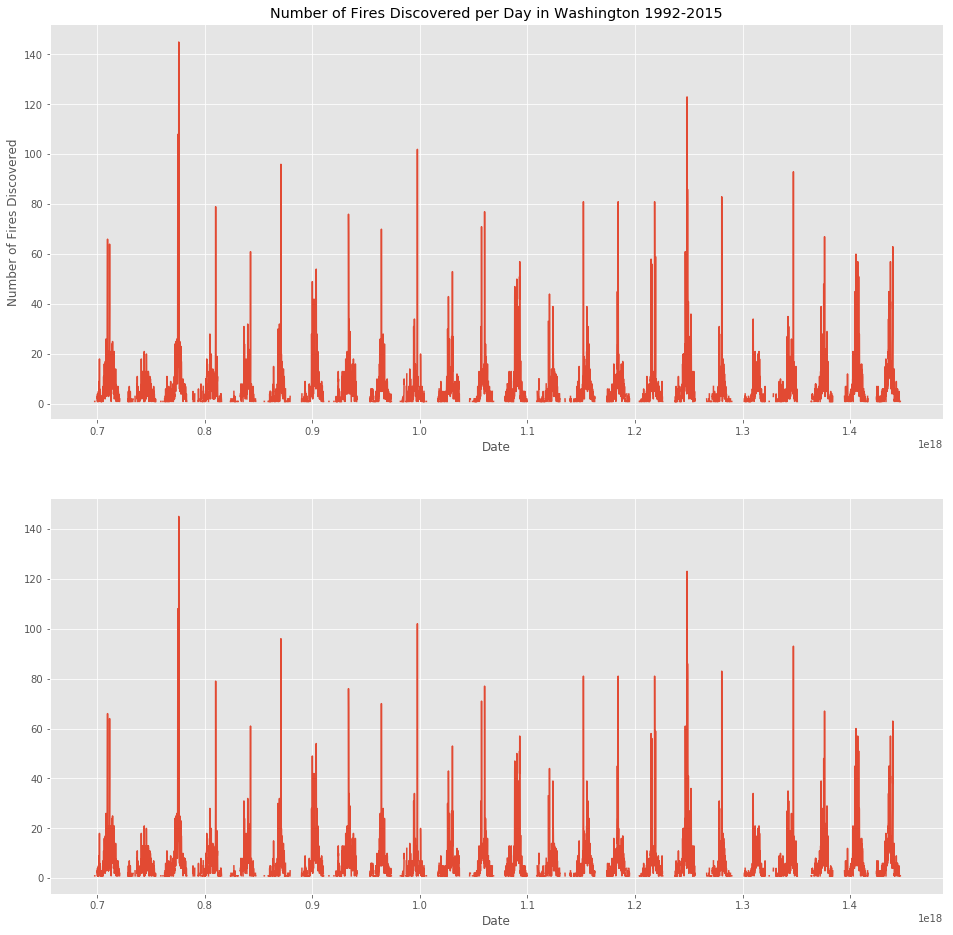

In [13]:
# Time series plots
index = pd.date_range(df["date_start"].min(), df["date_start"].max())
groupby_date = df.groupby("date_start")
count_timeseries = pd.Series(data = groupby_date['fire_year'].count(), index=index)

fig, axs = plt.subplots(2,1,figsize=(16,16))

axs[0].plot(count_timeseries.index, count_timeseries.values)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Number of Fires Discovered')
axs[0].set_title('Number of Fires Discovered per Day in Washington 1992-2015')

axs[1].plot(count_timeseries.index, count_timeseries.values)
axs[1].set_xlabel('Date')
axs[1].set_xlim((pd.Timestamp('2010-01-01 00:00:00'), pd.Timestamp('2015-11-27 00:00:00')))
#axs[1].set_xlim('2010-01-01 00:00:00', '2015-11-27 00:00:00')
axs[1].set_ylim(-5,50)
axs[1].set_ylabel('Number of Fires Discovered')
axs[1].set_title('Number of Fires Discovered per Day in Washington 2010-2015')


In [ ]:
year_count = df.groupby('fire_year').count()['state']

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(year_count.index, year_count.values)
ax.set_xlabel('Year')
ax.set_ylabel('Number of fires')
ax.set_title("Number of fire per year in Washington 1992-2015")

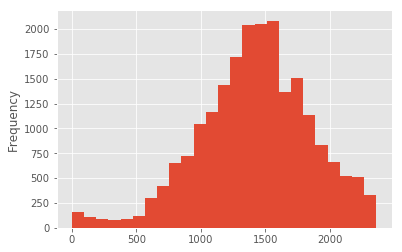

In [134]:
df['discovery_time'].plot(kind='hist', bins=25)

In [ ]:
# Do I want this?
#keep_cols = ['fire_year', 'date_start', 'month', 'discovery_doy',
#                'latitude', 'longitude']
#df = df.loc[:,keep_cols]

### Complile weather data

In [52]:
file_path = 'data/weather/'

In [53]:
weather_files = ['WA_1992_1.csv',  'WA_1996_2.csv',  'WA_2001_2.csv',  'WA_2006_2.csv',  'WA_2011_2.csv',
                 'WA_1992_2.csv',  'WA_1997_1.csv',  'WA_2002_1.csv',  'WA_2007_1.csv',  'WA_2012_1.csv',
                 'WA_1993_1.csv',  'WA_1997_2.csv',  'WA_2002_2.csv',  'WA_2007_2.csv',  'WA_2012_2.csv',
                 'WA_1993_2.csv',  'WA_1998_1.csv',  'WA_2003_1.csv',  'WA_2008_1.csv',  'WA_2013_1.csv',
                 'WA_1994_1.csv',  'WA_1998_2.csv',  'WA_2003_2.csv',  'WA_2008_2.csv',  'WA_2013_2.csv',
                 'WA_1994_2.csv',  'WA_1999_1.csv',  'WA_2004_1.csv',  'WA_2009_1.csv',  'WA_2014_1.csv',
                 'WA_1994_3.csv',  'WA_1999_2.csv',  'WA_2004_2.csv',  'WA_2009_2.csv',  'WA_2014_2.csv',
                 'WA_1995_1.csv',  'WA_2000_1.csv',  'WA_2005_1.csv',  'WA_2010_1.csv',  'WA_2015_1.csv',
                 'WA_1995_2.csv',  'WA_2000_2.csv',  'WA_2005_2.csv',  'WA_2010_2.csv',  'WA_2015_2.csv',
                 'WA_1996_1.csv',  'WA_2001_1.csv',  'WA_2006_1.csv',  'WA_2011_1.csv']

In [54]:
weather_features = ['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'PRCP',
                    'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS']

In [51]:
def get_weather_data(file_path, files, features):
    for file_name in files:
        with open(file_path + file_name) as f:
            reader = csv.reader(f)
            header = next(reader)
            col_indeces = [header.index(var) for var in features]
            for row in reader:
                yield parser(row, col_indeces)
            
def parser(row, col_indeces):
    return [row[i] for i in col_indeces]
    
    

In [55]:
weather_data_generator = get_weather_data(file_path, weather_files, weather_features)

In [56]:
df_weather_test = pd.DataFrame(weather_data_generator, columns=weather_features)

In [62]:
df_weather_test.head()

,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS
0,USC00458034,47.8663,-121.7175,51.8,1992-01-01,0.00,0.0,0,,53,41,47
1,USC00458034,47.8663,-121.7175,51.8,1992-01-02,1.20,0.0,0,,51,39,40
2,USC00458034,47.8663,-121.7175,51.8,1992-01-03,0.03,0.0,0,,48,39,45
3,USC00458034,47.8663,-121.7175,51.8,1992-01-04,0.32,0.0,0,,47,38,38
4,USC00458034,47.8663,-121.7175,51.8,1992-01-05,0.18,0.0,0,,48,33,33


In [92]:
weather_data_generator

<generator object get_weather_data at 0x12627c410>

In [93]:
with open('data/compiled_weather.csv', 'w') as f:
    fwriter = csv.writer(f, delimiter=',',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for row in weather_data_generator:
        fwriter.writerow([row])

In [94]:
!head data/compiled_weather.csv

## Weather data

In [ ]:
weather = pd.read_csv('data/all_weather')

In [ ]:
weather_keep = ['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'PRCP',
                    'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS'] # thunder 'WV03' 'WT03'
weather = weather[weather_keep]

In [ ]:
columns = weather.columns
columns = columns.str.lower()
weather.columns = columns

In [ ]:
weather['date'] = pd.to_datetime(weather['date'])
weather['month'] = weather['date'].map(lambda x : x.month)
weather['year'] = weather['date'].map(lambda x : x.year)
weather['doy'] = weather['date'].map(lambda x : x.dayofyear)

In [ ]:
weather_sorted = weather.sort_values(['year', 'doy', 'longitude', 'latitude'])

In [ ]:
weather_sorted['snow'].fillna(value=0.0, inplace=True)
weather_sorted['snwd'].fillna(value=0.0, inplace=True)
weather_sorted['tmax'].fillna(method='ffill', inplace=True)
weather_sorted['tmin'].fillna(method='ffill', inplace=True)

### Map weather to fire data

In [ ]:
group_station = weather_sorted.groupby('station')
station_coordinates = group_station[['latitude', 'longitude']].max()

In [ ]:
def get_nearby_station(lat, long, stations=station_coordinates):
    min_d = 1000
    station = stations.index[0]
    for i in range(len(stations)):
        distance = np.sqrt((lat-stations.iloc[i,0])**2 + (long-stations.iloc[i,1])**2)
        if distance < min_d:
            min_d = distance
            station = stations.index[i]
    return station

In [ ]:
df_eda = df.loc[df['fire_year'] > 2013]

In [ ]:
df_eda['weather_station'] = np.vectorize(get_nearby_station)(df_eda['latitude'], df_eda['longitude'])

In [ ]:
def get_weather(doy, year, station, weather=weather_sorted):
    return weather['tmax'].loc[(weather['station'] == station) &
                                (weather['year'] == year) &
                               (weather['doy'] == doy)]

In [ ]:
df_eda = pd.merge(df_eda, weather_sorted, how='left', left_on=['weather_station', 'fire_year', 'discovery_doy'],
                  right_on=['station', 'year', 'doy'])

In [ ]:
df_eda.head()

In [ ]:
weather_sorted['tmax'].loc[(weather_sorted['station'] == 'USR0000WFTA') &
                                (weather_sorted['year'] == 2014)
                              & (weather_sorted['doy'] == 1)].values

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
univariate_plot('tmax_fire_day', ax, df=df_eda)

### Saprk

In [139]:
import pyspark as ps


In [140]:
spark = (ps.sql.SparkSession.builder 
            .master("local[4]") 
            .appName("weather") 
            .getOrCreate())

In [145]:
df_weather = spark.read.csv('data/all_weather.csv',
                         header=True,
                         quote='"',
                         sep=",",           
                         inferSchema=True)

In [146]:
df_weather.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ACMH: string (nullable = true)
 |-- ACMH_ATTRIBUTES: string (nullable = true)
 |-- ACSH: string (nullable = true)
 |-- ACSH_ATTRIBUTES: string (nullable = true)
 |-- AWND: string (nullable = true)
 |-- AWND_ATTRIBUTES: string (nullable = true)
 |-- DAEV: string (nullable = true)
 |-- DAEV_ATTRIBUTES: string (nullable = true)
 |-- DAPR: string (nullable = true)
 |-- DAPR_ATTRIBUTES: string (nullable = true)
 |-- DASF: string (nullable = true)
 |-- DASF_ATTRIBUTES: string (nullable = true)
 |-- DAWM: string (nullable = true)
 |-- DAWM_ATTRIBUTES: string (nullable = true)
 |-- EVAP: string (nullable = true)
 |-- EVAP_ATTRIBUTES: string (nullable = true)
 |-- FMTM: string (nullable = true)
 |-- FMTM_ATTRIBUTES: string (nullable = true)
 |-- MDEV: stri

In [ ]:
group_station_month = df_weather_2014.groupby(['STATION', 'MONTH'])
monthly_precip = group_station_month['PRCP'].sum()
monthly_snow = group_station_month['SNOW'].sum()
monthly_tmax = group_station_month['TMAX'].mean()
monthly_tmin = group_station_month['TMIN'].mean()
monthly_tobs = group_station_month['TOBS'].mean()
 

In [ ]:
group_station = df_weather_2014.groupby('STATION')
station_coordinates = group_station[['LATITUDE', 'LONGITUDE']].max()

In [ ]:
df_monthly_weather = pd.concat([monthly_precip, monthly_snow, monthly_tmax, monthly_tmin, monthly_tobs], axis=1)

In [ ]:
#df_monthly_weather.reset_index(level=0, inplace=True)
df_monthly_weather.reset_index(level=1, inplace=True)
df_monthly_weather.head()

In [ ]:
station_coordinates.plot(x='LONGITUDE', y='LATITUDE', kind='scatter', alpha=.6, figsize=(10,8), title='Location of weather stations')


In [ ]:

sns.lmplot( x='LONGITUDE', y='LATITUDE', data=df_fires_2014, fit_reg=False, hue='FIRE_SIZE_CLASS', 
            size=10, legend=True)


In [ ]:
df_fires_2014.groupby('FIRE_SIZE_CLASS')['DATE'].count().plot(kind='bar')

In [ ]:
df_fires_2014.groupby('FIRE_SIZE_CLASS')['DATE'].count()

In [ ]:
def get_nearby_station(lat, long, stations=station_coordinates):
    min_d = 1000
    station = stations.index[0]
    for i in range(len(stations)):
        distance = np.sqrt((lat-stations.iloc[i,0])**2 + (long-stations.iloc[i,1])**2)
        if distance < min_d:
            min_d = distance
            station = stations.index[i]
    return station
            
        
        

In [ ]:
def get_weather(month, station, weather=df_monthly_weather):
    month = min(1, month-1)
    return df_monthly_weather['PRCP'].loc[(df_monthly_weather['STATION'] == station) &
                                         (df_monthly_weather['MONTH'] == month)].values

In [ ]:
df_fires_2014['STATION'] = np.vectorize(get_nearby_station)(df_fires_2014['LATITUDE'], df_fires_2014['LONGITUDE'])

In [ ]:
df_fires_2014['PRCP'] = np.vectorize(get_weather)(df_fires_2014['MONTH'], df_fires_2014['STATION'])

In [ ]:
df_monthly_weather['PRCP'].loc[(df_monthly_weather['STATION'] == 'CA001018611') &
                                         (df_monthly_weather['MONTH'] == 10)].values

In [ ]:
len(df_monthly_weather['STATION'].unique())

In [ ]:
min(1,2)

### Spatial grid

In [ ]:
min_lat = df['latitude'].min()
max_lat = df['latitude'].max()
min_long = df['longitude'].min()
max_long = df['longitude'].max()
print(min_lat, max_lat, min_long, max_long)

In [ ]:
lat_steps = 100
long_steps = 300

lat_grid = np.linspace(min_lat, max_lat, lat_steps)
long_grid = np.linspace(min_long, max_long, long_steps)

In [ ]:
np.argsort(lat_grid - 46.7)

In [ ]:
def get_grid(lat, long, lat_grid, long_grid):
    

In [ ]:
lat_grid = np.linspace(max_lat, min_lat, 100)
long_grid = np.linspace(min_long, max_long, 100)

In [ ]:
one_month_weahter = df_monthly_weather[df_monthly_weather['MONTH'] == 6]

In [ ]:
one_month_weahter = pd.concat([one_month_weahter,station_coordinates], axis=1)

In [ ]:
one_month_fires = df_fires_2014[df_fires_2014['MONTH']==7]

In [ ]:
one_month_fires.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(one_month_weahter['LONGITUDE'], one_month_weahter['LATITUDE'], c=one_month_weahter['PRCP'], alpha=0.5)
ax.scatter(one_month_fires['LONGITUDE'], one_month_fires['LATITUDE'], alpha=0.6)
#ax.legend()


In [ ]:
len(one_month_weahter['PRCP'])

In [ ]:
one_month_weahter.loc['CA001018611','TMAX']

In [ ]:
prcp_map = np.zeros([100,100])

In [ ]:
prcp_map.shape

In [ ]:
def get_coord_weather(lat, long, measurement='PRCP', df=one_month_weahter):
    station = get_nearby_station(lat, long)
    return df.loc[station, measurement]
    
    

In [ ]:
np.where(prcp_map)

In [ ]:
map_df = pd.DataFrame(prcp_map, index=lat_grid, columns=long_grid)

In [ ]:
map_df.head()

In [ ]:
for i, long in enumerate(long_grid):
    if i%10==0: print (i)
    map_df.iloc[:,i] = np.vectorize(get_coord_weather)(lat_grid, np.array([long]*len(long_grid)))

In [ ]:
map_df_fill = map_df.fillna(method='ffill')
map_df_fill = map_df_fill.fillna(method='bfill')


In [ ]:
fig, ax = plt.subplots(figsize=(14,8))

lat_grid = np.linspace(max_lat, min_lat, 100)
long_grid = np.linspace(min_long, max_long, 100)
long_conversion = (one_month_fires['LONGITUDE']-min_long) * 100/(max_long-min_long)
lat_conversion = (one_month_fires['LATITUDE']-max_lat) * 100/(min_lat-max_lat)

my_cmap = sns.light_palette("Blue", as_cmap=True)

#ax.set_ylim(min_lat, max_lat)
#ax.set_xlim(min_long, max_long)
#ax.imshow(map_df_fill.values, cmap='hot', norm=True)
sns.heatmap(map_df_fill, alpha=1, cmap=my_cmap, center=1, ax=ax, label='Total precipitation')
ax.scatter(long_conversion, lat_conversion,  c='r', alpha=0.6, label='Wildfires')
ax.legend()
ax.set_title('Location of Wildfires and Total Precipitation in the Previous Month')



In [ ]:
# weather heatmap with fire locations 
def weather_heatmap(month, measurement, lat_grid=lat_grid, long_grid=long_grid, df_monthly_weather=df_monthly_weather, 
                    station_coordinates=station_coordinates, df_fires_2014=df_fires_2014):

    one_month_weahter = df_monthly_weather[df_monthly_weather['MONTH'] == month-1]
    one_month_weahter = pd.concat([one_month_weahter,station_coordinates], axis=1)
    one_month_fires = df_fires_2014[df_fires_2014['MONTH']==month]

    prcp_map = np.zeros([100,100])
    map_df = pd.DataFrame(prcp_map, index=lat_grid, columns=long_grid)

    for i, long in enumerate(long_grid):
        if i%10==0: print (i)
        map_df.iloc[:,i] = np.vectorize(get_coord_weather)(lat_grid, np.array([long]*len(long_grid)), measurement)
        
    map_df_fill = map_df.fillna(method='ffill')
    map_df_fill = map_df_fill.fillna(method='bfill')
    
    min_lat = lat_grid[-1]
    max_lat = lat_grid[0]
    min_long = long_grid[0]
    max_long = long_grid[-1]

    fig, ax = plt.subplots(figsize=(14,8))

    long_conversion = (one_month_fires['LONGITUDE']-min_long) * 100/(max_long-min_long)
    lat_conversion = (one_month_fires['LATITUDE']-max_lat) * 100/(min_lat-max_lat)

    my_cmap = sns.light_palette("Blue", as_cmap=True)

    #ax.set_ylim(min_lat, max_lat)
    #ax.set_xlim(min_long, max_long)
    #ax.imshow(map_df_fill.values, cmap='hot', norm=True)
    sns.heatmap(map_df_fill, alpha=1, cmap=my_cmap, center=1, ax=ax, label=measurement)
    ax.scatter(long_conversion, lat_conversion,  c='r', alpha=0.6, label='Wildfires')
    ax.legend()
    ax.set_title('Location of Wildfires in month {} and {} in the Previous Month'.format(month, measurement))

In [ ]:
weather_heatmap(8, 'TMAX')

In [ ]:
weather_heatmap(9, 'PRCP')